In [1]:
import pikepdf
import zlib
import sys # Used for error handling, might print instead of exiting in notebook

# Extract graph lines

In [2]:
import fitz  # PyMuPDF
import re
import xml.etree.ElementTree as ET
import io
from PIL import Image
import cairosvg  # You might need to install this: pip install cairosvg

def extract_graph_lines(input_pdf_path, output_pdf_path):
    """
    Extract only the graph line elements from a PDF and create a new PDF with just those lines.
    Uses stroke pattern recognition to identify graph lines.
    
    Args:
        input_pdf_path (str): Path to the input PDF file
        output_pdf_path (str): Path where the output PDF will be saved
    """
    # Open the PDF
    doc = fitz.open(input_pdf_path)
    page = doc[0]  # Assuming we're working with the first page
    
    # Get SVG content from the page
    svg_text = page.get_svg_image(text_as_path=True)
    
    # Parse the SVG
    namespace = {'svg': 'http://www.w3.org/2000/svg'}
    root = ET.fromstring(svg_text)
    
    # Find all path elements in the SVG
    paths = root.findall('.//svg:path', namespace)
    
    # Create a new SVG document to hold our filtered content
    new_svg = ET.Element('svg', {
        'xmlns': 'http://www.w3.org/2000/svg',
        'width': str(page.rect.width),
        'height': str(page.rect.height),
        'viewBox': f"0 0 {page.rect.width} {page.rect.height}"
    })
    
    # Filter paths and add graph lines to new SVG
    for path in paths:
        if is_graph_line(path, namespace):
            new_svg.append(path)
    
    # Convert the new SVG to string
    new_svg_str = ET.tostring(new_svg, encoding='utf-8', method='xml').decode('utf-8')
    
    # Create a new PDF document
    new_doc = fitz.open()
    new_page = new_doc.new_page(width=page.rect.width, height=page.rect.height)
    
    # Method 1: Try to use SVG rendering via Cairo (more reliable)
    try:
        # Convert SVG to PNG using cairosvg
        png_data = cairosvg.svg2png(bytestring=new_svg_str.encode('utf-8'))
        
        # Create an image from the PNG data
        img = fitz.Pixmap(png_data)
        
        # Insert the image into the page
        new_page.insert_image(new_page.rect, pixmap=img)
    except (ImportError, Exception) as e:
        print(f"Cairo rendering failed: {e}, trying alternative method...")
        
        # Method 2: Alternative approach using PIL
        try:
            # Write SVG to temporary file
            import tempfile
            with tempfile.NamedTemporaryFile(suffix='.svg', delete=False) as temp:
                temp_name = temp.name
                temp.write(new_svg_str.encode('utf-8'))
            
            # Use draw_file which is more widely available across PyMuPDF versions
            new_page.draw_file(temp_name, dpi=300)
            
            # Clean up the temporary file
            import os
            os.unlink(temp_name)
        except Exception as e2:
            # Method 3: Last resort - render as PNG with PIL or similar
            print(f"Alternative method failed: {e2}, using basic method...")
            
            # For this backup method, we'll use a simple rect to show where the graph should be
            # Just to ensure we get some output rather than failing completely
            rect = fitz.Rect(0, 0, page.rect.width, page.rect.height)
            new_page.draw_rect(rect, color=(0, 0, 0), width=1)
            
            # Add a text annotation explaining the issue
            new_page.insert_text((50, 50), "Graph rendering failed - see console for details")
    
    # Save the new PDF
    new_doc.save(output_pdf_path)
    new_doc.close()
    doc.close()
    
    print(f"Graph lines extracted and saved to {output_pdf_path}")

def is_graph_line(path_element, namespace):
    """
    Determine if a path element represents a graph line based on stroke pattern.
    
    Args:
        path_element: An XML Element representing an SVG path
        namespace: The SVG namespace dictionary
        
    Returns:
        bool: True if the path appears to be a graph line, False otherwise
    """
    # Get path data
    d = path_element.get('d', '')
    style = path_element.get('style', '')
    
    # Check for line characteristics - scoring approach
    score = 0
    
    # 1. Long continuous paths (not short decorative elements)
    if len(d) > 50:
        score += 1
    
    # 2. Contains mostly linear commands (M, L, H, V)
    commands = re.findall(r'[MLHVCSQTAZmlhvcsqtaz]', d)
    if commands:
        line_commands = [c for c in commands if c.lower() in 'mlhv']
        if len(line_commands) / len(commands) > 0.7:
            score += 2
    
    # 3. Has a stroke style and no or transparent fill
    if 'stroke:' in style and ('fill:none' in style or 'fill:transparent' in style):
        score += 2
    
    # 4. Reasonable stroke width for a graph line
    stroke_width_match = re.search(r'stroke-width:\s*(\d+\.?\d*)', style)
    if stroke_width_match:
        width = float(stroke_width_match.group(1))
        if 0.5 <= width <= 3.0:  # Typical graph line thickness
            score += 1
    
    # 5. Spans significant portion of canvas (analyze coordinates)
    coords = re.findall(r'-?\d+\.?\d*', d)
    if len(coords) >= 4:
        try:
            # Extract x and y coordinates
            x_coords = [float(coords[i]) for i in range(0, len(coords), 2) if i+1 < len(coords)]
            y_coords = [float(coords[i+1]) for i in range(0, len(coords), 2) if i+1 < len(coords)]
            
            if x_coords and y_coords:
                x_range = max(x_coords) - min(x_coords)
                y_range = max(y_coords) - min(y_coords)
                
                # Graph lines typically span significant distance
                if x_range > 100 or y_range > 100:
                    score += 2
                
                # Check for data-like variation in y values
                if len(set(y_coords)) > len(y_coords) * 0.3:  # Some variation in y values
                    score += 1
        except Exception:
            pass  # Skip if there's an error processing the coordinates
    
    # Return True if the path meets enough criteria to be considered a graph line
    return score >= 5  # Threshold can be adjusted based on testing

#pdf_path = "/Users/air/Desktop/BSC Projects/PDFconverter/PDF2JSON/Correct/format2/test/test_format2.pdf"

# Example usage
#extract_graph_lines(pdf_path, 'graph_lines_only.pdf')

# Extract SVG Data from PDF

Extract embedded SVG data from PDF content streams and save as SVG files

In [3]:
import fitz  # PyMuPDF
import tempfile
import traceback
import os
from xml.dom import minidom
import xml.etree.ElementTree as ET

def extract_svg_from_pdf(input_pdf_path, output_svg_path=None):
    """
    Extract SVG data from PDF using PyMuPDF and save to a temporary file.
    
    Args:
        input_pdf_path (str): Path to the input PDF file
        output_svg_path (str, optional): Path for output SVG file (if None, uses a temp file)
    
    Returns:
        dict: Results with success status, SVG content, and temp file path
    """
    results = {
        'success': False,
        'svg_content': None,
        'temp_file_path': None,
        'errors': []
    }
    
    try:
        # Open the PDF and get the first page
        doc = fitz.open(input_pdf_path)
        if doc.page_count == 0:
            results['errors'].append("PDF has no pages")
            return results
            
        page = doc[0]  # Get first page
        
        # Convert page to SVG
        svg_text = page.get_svg_image()
        
        if not svg_text or '<svg' not in svg_text:
            results['errors'].append("Failed to generate SVG from page")
            doc.close()
            return results
        
        # SVG extraction succeeded
        results['svg_content'] = svg_text
        
        # Create a temporary file to store the SVG
        temp_file = tempfile.NamedTemporaryFile(suffix='.svg', delete=False)
        results['temp_file_path'] = temp_file.name
        
        # Write SVG to the temporary file
        with open(temp_file.name, 'w', encoding='utf-8') as f:
            f.write(svg_text)
        
        # # Save to output path if specified (commented out)
        # if output_svg_path:
        #     try:
        #         # Pretty print the SVG if possible
        #         try:
        #             root = ET.fromstring(svg_text)
        #             pretty_xml = minidom.parseString(ET.tostring(root)).toprettyxml(indent="  ")
        #             pretty_xml = '\n'.join(line for line in pretty_xml.split('\n') if line.strip())
        #             svg_text = pretty_xml
        #         except:
        #             pass  # Use original if formatting fails
        #         
        #         with open(output_svg_path, 'w', encoding='utf-8') as f:
        #             f.write(svg_text)
        #     except Exception as e:
        #         results['errors'].append(f"Error saving to output path: {str(e)}")
        
        results['success'] = True
        doc.close()
        
    except ImportError:
        results['errors'].append("PyMuPDF not available for SVG conversion")
    except Exception as e:
        results['errors'].append(f"Error extracting SVG: {str(e)}")
        traceback.print_exc()
    
    return results

# Example usage
# test_file = "/Users/air/Desktop/BSC Projects/PDFconverter/PDF2JSON/graph_lines_only.pdf"
# result = extract_svg_from_pdf(test_file)

# if result['success']:
#     print(f"SVG extraction successful: {result['temp_file_path']}")
# else:
#     print("SVG extraction failed:", result['errors'])

# Vector graphics extraction from pdf

In [4]:
import xml.etree.ElementTree as ET
import re
import tempfile
import os
from pathlib import Path

def filter_svg_stroke_width_15(svg_file_path, output_file_path=None):
    """
    Filter an SVG file to keep only paths with stroke-width="15".
    These are typically the ECG waveform paths.
    
    Args:
        svg_file_path (str): Path to the input SVG file (can be a temp file)
        output_file_path (str, optional): Path for output file. If None, creates a temp file
    
    Returns:
        dict: Results with success status, filtered content, and temp file path
    """
    result = {
        'success': False,
        'svg_content': '',
        'filtered_paths': 0,
        'total_paths': 0,
        'temp_file_path': None,
        'output_path': '',
        'errors': []
    }
    
    try:
        # Check if input file exists
        if not os.path.exists(svg_file_path):
            result['errors'].append(f"Input file not found: {svg_file_path}")
            return result
        
        # Read the SVG file
        with open(svg_file_path, 'r', encoding='utf-8') as f:
            svg_content = f.read()
        
        # Parse the SVG content
        try:
            root = ET.fromstring(svg_content)
        except ET.ParseError as e:
            result['errors'].append(f"XML parsing error: {e}")
            return result
        
        # Define namespace (if any)
        namespace = {'svg': 'http://www.w3.org/2000/svg'}
        
        # Find all path elements
        paths = root.findall('.//path') + root.findall('.//svg:path', namespace)
        result['total_paths'] = len(paths)
        
        # Filter paths with stroke-width="15"
        filtered_paths = []
        
        for path in paths:
            stroke_width = path.get('stroke-width')
            style = path.get('style', '')
            
            # Check stroke-width attribute
            is_stroke_15 = stroke_width == '15'
            
            # Also check in style attribute
            if not is_stroke_15 and style:
                style_match = re.search(r'stroke-width\s*:\s*15(?:px|pt|)?(?:;|$)', style)
                is_stroke_15 = style_match is not None
            
            if is_stroke_15:
                filtered_paths.append(path)
        
        result['filtered_paths'] = len(filtered_paths)
        
        if result['filtered_paths'] == 0:
            result['errors'].append("No paths with stroke-width='15' found")
            return result
        
        # Create new SVG with only filtered paths
        # Create a new root element with same attributes
        new_root = ET.Element(root.tag, root.attrib)
        
        # Copy namespace declarations
        for key, value in root.attrib.items():
            if key.startswith('xmlns'):
                new_root.set(key, value)
        
        # Add filtered paths to new root
        for path in filtered_paths:
            new_root.append(path)
        
        # Convert back to string
        filtered_svg = ET.tostring(new_root, encoding='unicode')
        
        # Add XML declaration
        if not filtered_svg.startswith('<?xml'):
            filtered_svg = '<?xml version="1.0" encoding="UTF-8"?>\n' + filtered_svg
        
        # Pretty format (optional)
        try:
            from xml.dom import minidom
            dom = minidom.parseString(filtered_svg)
            filtered_svg = dom.toprettyxml(indent="  ")
            # Remove empty lines
            filtered_svg = '\n'.join(line for line in filtered_svg.split('\n') if line.strip())
        except:
            pass  # Use unformatted if pretty formatting fails
        
        result['svg_content'] = filtered_svg
        
        # Create a temporary output file if no specific path is provided
        if output_file_path is None:
            temp_file = tempfile.NamedTemporaryFile(suffix='_stroke15_only.svg', delete=False)
            output_file_path = temp_file.name
            temp_file.close()
            result['temp_file_path'] = output_file_path
        
        # Write filtered SVG to output file
        with open(output_file_path, 'w', encoding='utf-8') as f:
            f.write(filtered_svg)
        
        result['output_path'] = output_file_path
        result['success'] = True
        
    except Exception as e:
        result['errors'].append(f"Unexpected error: {str(e)}")
    
    return result

# Example usage with the extract_svg_from_pdf function:
# First extract SVG from PDF
test_file = "/Users/air/Desktop/BSC Projects/PDFconverter/PDF2JSON/Correct/format2/test/test_format2.pdf"
extract_result = extract_svg_from_pdf(test_file)
if extract_result['success']:
    # Then filter the extracted SVG to keep only stroke-width=15 paths
    filter_result = filter_svg_stroke_width_15(extract_result['temp_file_path'])
    
    if filter_result['success']:
        print(f"Successfully filtered SVG: {filter_result['filtered_paths']} paths kept")
        print(f"Filtered SVG saved to: {filter_result['temp_file_path']}")
    else:
        print("SVG filtering failed:", filter_result['errors'])
else:
    print("SVG extraction failed:", extract_result['errors'])

# To save to a specific file instead of a temp file (commented out)
if extract_result['success']:
    output_path = "filtered_ecg.svg"
    filter_result = filter_svg_stroke_width_15(extract_result['temp_file_path'], output_path)


Successfully filtered SVG: 21 paths kept
Filtered SVG saved to: /var/folders/r0/xbx31xpj0554br082pwpt4sc0000gn/T/tmpei2evp9p_stroke15_only.svg


# Signal extraction

-Turn svg graph files into numerical data

## Extract: Convert SVG paths into coordinate points

In [5]:
""" Approach using the matrix transformation and move commands"""

import xml.etree.ElementTree as ET
import numpy as np
import re
from pathlib import Path

def extract_ecg_data_from_svg(svg_file_path):
    """
    Extract ECG waveform data from an SVG file with stroke-width='15' paths.
    
    Args:
        svg_file_path (str): Path to the filtered SVG file
        
    Returns:
        dict: Dictionary of ECG data with lead labels as keys
    """
    # Define path labels in order according to specification
    path_labels = [
        'calibration_1', 'calibration_2', 'calibration_3',
        'I', 'II', 'III', 'aVR', 'aVL', 'aVF',
        'V1', 'V2', 'V3', 'V4', 'V5', 'V6',
        'calibration_4', 'calibration_5', 'calibration_6',
        'V1_10sec', 'II_10sec', 'V5_10sec'
    ]
    
    # Initialize results dictionary
    result = {
        'success': False,
        'data': {},
        'errors': [],
        'svg_info': {
            'width': 0,
            'height': 0,
            'viewBox': '',
            'paths_found': 0
        }
    }
    
    try:
        # Parse SVG file
        tree = ET.parse(svg_file_path)
        root = tree.getroot()
        
        # Extract SVG dimensions
        result['svg_info']['width'] = float(root.get('width', 792))
        result['svg_info']['height'] = float(root.get('height', 612))
        result['svg_info']['viewBox'] = root.get('viewBox', '0 0 792 612')
        
        # Find all path elements (handle namespace)
        namespace = {'ns0': 'http://www.w3.org/2000/svg'}
        paths = root.findall('.//ns0:path', namespace)
        
        # If no paths found with namespace, try without namespace
        if not paths:
            paths = root.findall('.//path')
        
        result['svg_info']['paths_found'] = len(paths)
        print(f"Found {len(paths)} paths in SVG file")
        
        # Process each path and assign label based on order
        for i, path in enumerate(paths):
            # Get label for this path based on order
            if i < len(path_labels):
                label = path_labels[i]
            else:
                label = f'unknown_{i+1}'
                
            print(f"Processing path {i+1}: {label}")
            
            # Extract transform matrix
            transform_attr = path.get('transform', '')
            matrix = parse_transform_matrix(transform_attr)
            
            # Extract path data
            d_attr = path.get('d', '')
            if not d_attr:
                print(f"  Warning: Path {i+1} has no 'd' attribute")
                result['errors'].append(f"Path {i+1} ({label}) has no 'd' attribute")
                continue
                
            # Parse path data into points
            points = parse_path_data(d_attr)
            
            # Apply matrix transformation to all points
            transformed_points = apply_transformation(points, matrix)
            
            # Store in result dictionary
            if transformed_points:
                # Separate into x and y arrays
                x_values = [p[0] for p in transformed_points]
                y_values = [p[1] for p in transformed_points]
                
                result['data'][label] = {
                    'x': np.array(x_values),
                    'y': np.array(y_values),
                    'matrix': matrix,
                    'points_count': len(transformed_points)
                }
                
                # Print stats about this lead
                print(f"  ✓ Extracted {len(transformed_points)} points for {label}")
                if len(x_values) > 0:
                    print(f"    X range: {min(x_values):.2f} to {max(x_values):.2f}")
                    print(f"    Y range: {min(y_values):.2f} to {max(y_values):.2f}")
            else:
                print(f"  ✗ No points extracted for {label}")
                result['errors'].append(f"No points extracted for {label}")
        
        result['success'] = True
        
    except Exception as e:
        print(f"Error extracting ECG data: {str(e)}")
        result['errors'].append(f"Error: {str(e)}")
    
    return result

def parse_transform_matrix(transform_str):
    """
    Parse SVG transform matrix attribute.
    
    Args:
        transform_str (str): Transform attribute string like "matrix(a,b,c,d,e,f)"
        
    Returns:
        dict: Matrix components as a dictionary
    """
    matrix = {'a': 1, 'b': 0, 'c': 0, 'd': 1, 'e': 0, 'f': 0}  # Default identity matrix
    
    if not transform_str:
        return matrix
    
    # Extract matrix values using regex
    match = re.search(r'matrix\s*\(\s*([^,]+),\s*([^,]+),\s*([^,]+),\s*([^,]+),\s*([^,]+),\s*([^,)]+)', transform_str)
    
    if match:
        try:
            matrix['a'] = float(match.group(1))  # x scale
            matrix['b'] = float(match.group(2))  # y skew
            matrix['c'] = float(match.group(3))  # x skew
            matrix['d'] = float(match.group(4))  # y scale
            matrix['e'] = float(match.group(5))  # x translation
            matrix['f'] = float(match.group(6))  # y translation
        except ValueError as e:
            print(f"Error parsing matrix values: {e}")
    
    return matrix

def parse_path_data(d_attr):
    """
    Parse SVG path data into a list of coordinate points.
    
    Args:
        d_attr (str): SVG path data string (d attribute)
        
    Returns:
        list: List of (x,y) coordinate tuples
    """
    points = []
    current_x, current_y = 0, 0  # Current position
    
    # Regular expressions to match commands and numbers
    command_regex = re.compile(r'([MLHVZCSQTAmlhvzcsqta])|([-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?)')
    
    # Split the path data into tokens (commands and numbers)
    tokens = command_regex.findall(d_attr)
    tokens = [t[0] if t[0] else t[1] for t in tokens if t[0] or t[1]]
    
    i = 0
    current_command = None
    
    while i < len(tokens):
        # Get the current token
        token = tokens[i]
        
        # If it's a command letter, update current_command
        if token.isalpha():
            current_command = token
            i += 1
        # Otherwise it's a number, process according to current command
        elif current_command:
            if current_command in 'Mm':  # Move commands
                if i + 1 < len(tokens):
                    x = float(token)
                    y = float(tokens[i+1])
                    
                    if current_command == 'm':  # Relative
                        current_x += x
                        current_y += y
                    else:  # Absolute
                        current_x = x
                        current_y = y
                    
                    points.append((current_x, current_y))
                    i += 2
                else:
                    i += 1
            
            elif current_command in 'Ll':  # Line commands
                if i + 1 < len(tokens):
                    x = float(token)
                    y = float(tokens[i+1])
                    
                    if current_command == 'l':  # Relative
                        current_x += x
                        current_y += y
                    else:  # Absolute
                        current_x = x
                        current_y = y
                    
                    points.append((current_x, current_y))
                    i += 2
                else:
                    i += 1
            
            elif current_command in 'Hh':  # Horizontal line
                x = float(token)
                
                if current_command == 'h':  # Relative
                    current_x += x
                else:  # Absolute
                    current_x = x
                
                points.append((current_x, current_y))
                i += 1
            
            elif current_command in 'Vv':  # Vertical line
                y = float(token)
                
                if current_command == 'v':  # Relative
                    current_y += y
                else:  # Absolute
                    current_y = y
                
                points.append((current_x, current_y))
                i += 1
            
            else:
                # Skip other commands for now (curves, arcs, etc.)
                i += 1
        else:
            # If we encounter a number without a command, skip it
            i += 1
    
    return points

def apply_transformation(points, matrix):
    """
    Apply SVG matrix transformation to a list of points.
    
    Args:
        points (list): List of (x,y) coordinate tuples
        matrix (dict): Matrix transformation values
        
    Returns:
        list: List of transformed (x,y) coordinate tuples
    """
    transformed_points = []
    
    # unsure if it should be absolute or not 
    #y_scale = abs(matrix['d'])
    
    for x, y in points:
        # Apply the matrix transformation: [a c e] [x]
        #                                 [b d f] [y]
        #                                 [0 0 1] [1]
        new_x = matrix['a'] * x + matrix['c'] * y + matrix['e']
        # Use absolute value of y scale while preserving the sign of any y-skew
        new_y = matrix['b'] * x + matrix['d'] * y + matrix['f']
        transformed_points.append((new_x, new_y))
    
    return transformed_points

# Example usage (without plotting)
svg_file = "filtered_ecg.svg"

if Path(svg_file).exists():
    print(f"Processing SVG file: {svg_file}")
    ecg_data = extract_ecg_data_from_svg(svg_file)
    
    if ecg_data['success']:
        print("\nECG Data Summary:")
        print(f"Total leads extracted: {len(ecg_data['data'])}")
        
        for lead, data in ecg_data['data'].items():
            print(f"  {lead}: {data['points_count']} points")
        
        # Example of how to access specific lead data
        if 'II' in ecg_data['data']:
            lead_II = ecg_data['data']['II']
            print("\nLead II Sample Data (first 5 points):")
            for i in range(min(5, len(lead_II['x']))):
                print(f"  Point {i+1}: ({lead_II['x'][i]:.2f}, {lead_II['y'][i]:.2f})")
    else:
        print("Failed to extract ECG data:")
        for error in ecg_data['errors']:
            print(f"  - {error}")
else:
    print(f"SVG file not found: {svg_file}")
    print("Please run filter_svg_stroke_width_15 function first to generate the SVG file.")
    
"""
This code takes a filtered SVG file (with only paths having stroke-width='15') and turns it into  numerical data.


"""


Processing SVG file: filtered_ecg.svg
Found 21 paths in SVG file
Processing path 1: calibration_1
  ✓ Extracted 60 points for calibration_1
    X range: 12.76 to 29.48
    Y range: 162.43 to 190.78
Processing path 2: calibration_2
  ✓ Extracted 60 points for calibration_2
    X range: 12.76 to 29.48
    Y range: 232.31 to 260.66
Processing path 3: calibration_3
  ✓ Extracted 60 points for calibration_3
    X range: 12.76 to 29.48
    Y range: 302.19 to 330.54
Processing path 4: I
  ✓ Extracted 1238 points for I
    X range: 30.62 to 205.96
    Y range: 158.54 to 195.77
Processing path 5: II
  ✓ Extracted 1238 points for II
    X range: 30.62 to 205.96
    Y range: 231.60 to 266.04
Processing path 6: III
  ✓ Extracted 1238 points for III
    X range: 30.62 to 205.96
    Y range: 326.40 to 341.06
Processing path 7: aVR
  ✓ Extracted 1238 points for aVR
    X range: 207.81 to 383.15
    Y range: 185.93 to 221.22
Processing path 8: aVL
  ✓ Extracted 1238 points for aVL
    X range: 207.81 

"\nThis code takes a filtered SVG file (with only paths having stroke-width='15') and turns it into  numerical data.\n\n\n"

## Extraction: Visually check plots

Plotting ECG leads in custom layout...


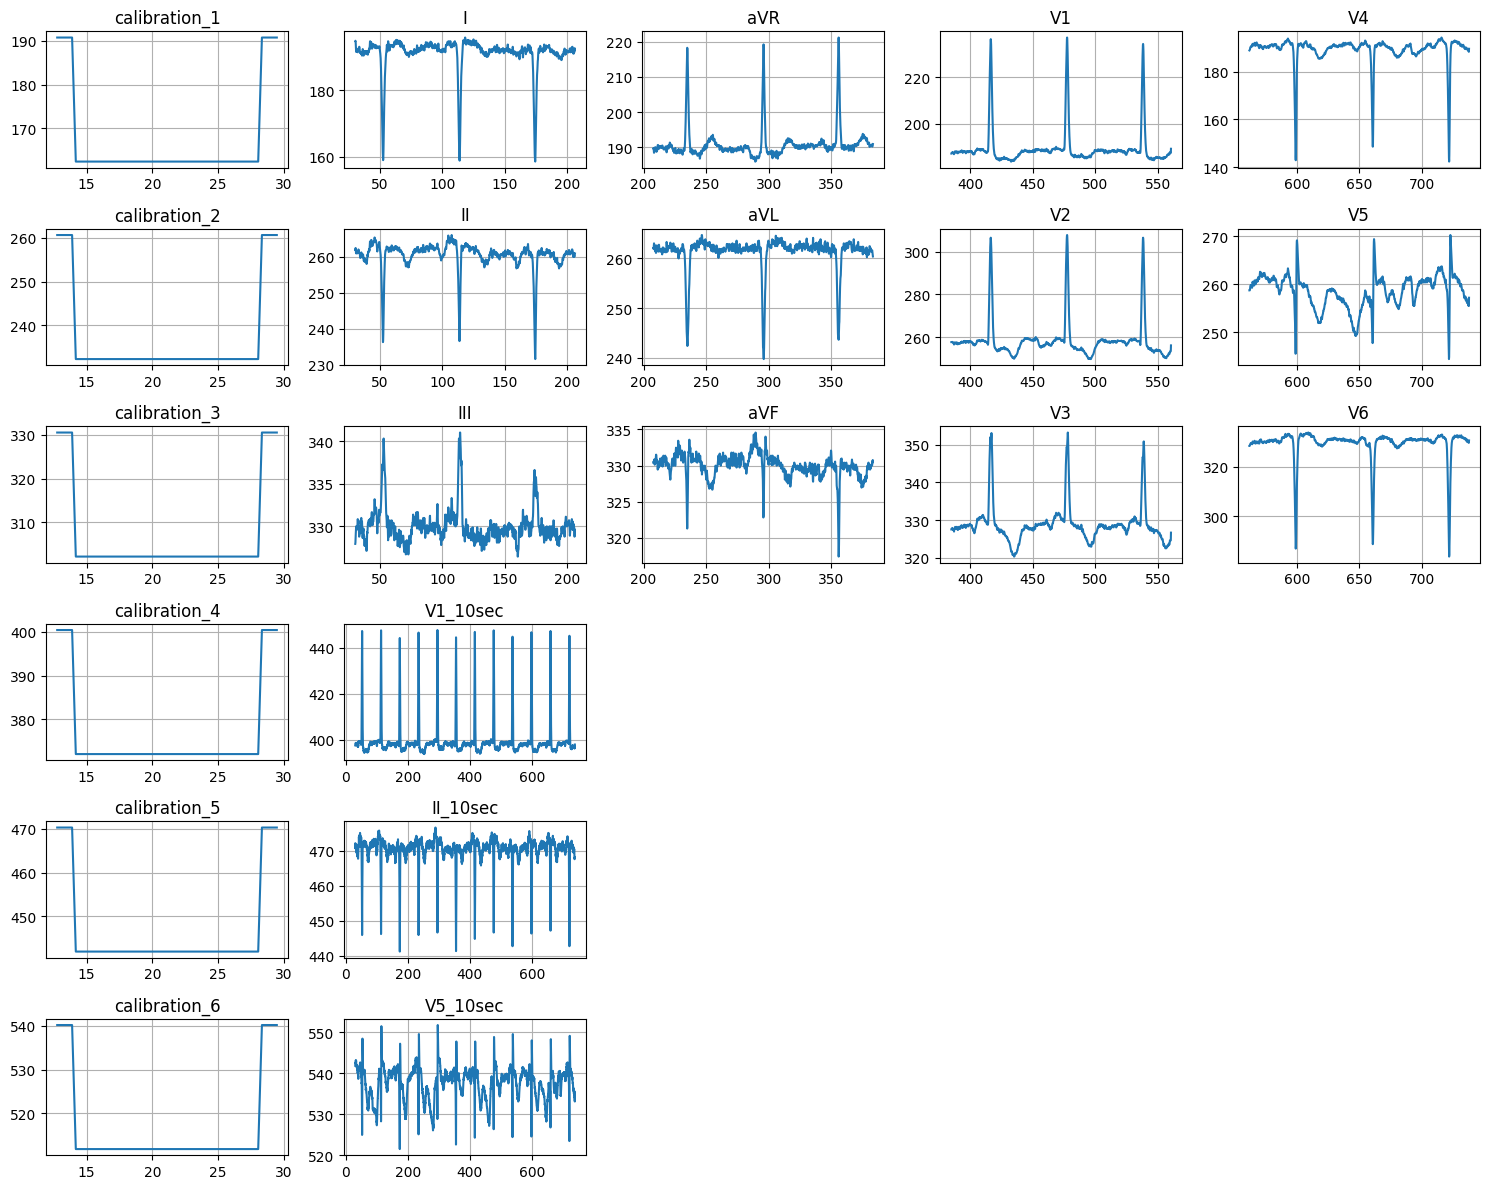

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_ecg_leads_custom_layout(ecg_data, figsize=(15, 12)):
    """
    Plot ECG leads in a specific custom layout:
    Row 1: calibration_1, I, aVR, V1, V4
    Row 2: calibration_2, II, aVL, V2, V5
    Row 3: calibration_3, III, aVF, V3, V6
    Row 4: calibration_4, V1_10sec, (empty), (empty), (empty)
    
    Args:
        ecg_data (dict): ECG data dictionary returned by extract_ecg_data_from_svg
        figsize (tuple): Figure size
    """
    if not ecg_data['success'] or not ecg_data['data']:
        print("No ECG data to plot")
        return
    
    # Define the specific layout
    layout = [
        ['calibration_1', 'I', 'aVR', 'V1', 'V4'],
        ['calibration_2', 'II', 'aVL', 'V2', 'V5'],
        ['calibration_3', 'III', 'aVF', 'V3', 'V6'],
        ['calibration_4', 'V1_10sec', None, None, None],
        ['calibration_5', 'II_10sec', None, None, None],
        ['calibration_6', 'V5_10sec', None, None, None]
    ]
    
    # Create the figure and axes
    fig, axs = plt.subplots(6, 5, figsize=figsize)
    
    # Plot each lead in its specified position
    for row_idx, row in enumerate(layout):
        for col_idx, lead in enumerate(row):
            ax = axs[row_idx, col_idx]
            
            if lead is None:
                # Empty plot
                ax.axis('off')
                continue
                
            if lead in ecg_data['data']:
                lead_data = ecg_data['data'][lead]
                ax.plot(lead_data['x'], lead_data['y'])
                ax.set_title(lead)
                ax.grid(True)
            else:
                ax.text(0.5, 0.5, f"Missing: {lead}", 
                       horizontalalignment='center',
                       verticalalignment='center',
                       transform=ax.transAxes)
                ax.set_title(f"{lead} (not found)")
                ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage (assuming ecg_data is available from the previous cell)
svg_file = "filtered_ecg.svg"

if Path(svg_file).exists() and 'ecg_data' in globals() and ecg_data['success']:
    print("Plotting ECG leads in custom layout...")
    plot_ecg_leads_custom_layout(ecg_data)
else:
    print("ECG data not available. Run the data extraction cell first.")

# Calibration

## Calibration: Get calibration values

In [7]:
def get_calibration(ecg_data):
    """
    Extracts the minimum and maximum Y values from each calibration wave
    in the ECG data (from extract_ecg_data_from_svg).

    Args:
        ecg_data (dict): Dictionary returned by extract_ecg_data_from_svg with key 'data'.

    Returns:
        dict: Dictionary mapping each calibration key to a tuple (min_y, max_y)
    """
    import numpy as np

    calibration_keys = ["calibration_1", "calibration_2", "calibration_3", "calibration_4","calibration_5", "calibration_6"]
    results = {}
    
    for key in calibration_keys:
        if key not in ecg_data.get('data', {}):
            print(f"{key}: Data not found")
            continue
        
        data = ecg_data['data'][key]
        y_arr = data['y']
        
        min_y = np.min(y_arr)
        max_y = np.max(y_arr)
        
        results[key] = (min_y, max_y)
        
        print(f"{key}:")
        print(f"  Y values: min = {min_y:.2f}, max = {max_y:.2f}")
    
    return results

# Example usage:
# Assuming ecg_data is a variable that holds the output dict from extract_ecg_data_from_svg
calibration_results = get_calibration(ecg_data)

calibration_1:
  Y values: min = 162.43, max = 190.78
calibration_2:
  Y values: min = 232.31, max = 260.66
calibration_3:
  Y values: min = 302.19, max = 330.54
calibration_4:
  Y values: min = 372.07, max = 400.42
calibration_5:
  Y values: min = 441.96, max = 470.31
calibration_6:
  Y values: min = 511.84, max = 540.19


## Calibration: Normalise amplitude values

In [8]:
""" Set to mV """
def apply_calibration_to_leads(ecg_data, calibration):
    """
    Applies calibration to lead waves to convert raw y values into mV.
    
    For calibration, the y max value (from calibration) represents 0 mV and 
    the y min represents 1 mV. Thus, for a lead sample y, the conversion is:
        mV = (cal_max - y) / (cal_max - cal_min)
    
    The calibration groups are defined as:
      - Calibration 1 (from calibration_1): applies to leads 'I', 'aVR', 'V1', 'V4'
      - Calibration 2 (from calibration_2): applies to leads 'II', 'aVL', 'V2', 'V5'
      - Calibration 3 (from calibration_3): applies to leads 'III', 'aVF', 'V3', 'V6'
      - Calibration 4 (from calibration_4): applies to lead 'V1_10sec'
    
    Args:
        ecg_data (dict): Dictionary returned by extract_ecg_data_from_svg with key 'data'
        calibration (dict): Dictionary from get_calibration mapping calibration keys to (min_y, max_y)
    
    Returns:
        dict: A dictionary mapping each lead key to a 1D numpy array of calibrated mV values.
    """
    import numpy as np

    # Define the calibration mapping for each lead
    cal_mapping = {
        'calibration_1': ['I', 'aVR', 'V1', 'V4'],
        'calibration_2': ['II', 'aVL', 'V2', 'V5'],
        'calibration_3': ['III', 'aVF', 'V3', 'V6'],
        'calibration_4': ['V1_10sec'],
        'calibration_5': ['II_10sec'],
        'calibration_6': ['V5_10sec']
    }
    
    calibrated_leads = {}
    
    for cal_key, leads in cal_mapping.items():
        if cal_key not in calibration:
            print(f"Calibration data not found for {cal_key}. Skipping its leads.")
            continue
        
        cal_min, cal_max = calibration[cal_key]
        amp = cal_max - cal_min
        if amp == 0:
            print(f"Warning: Zero amplitude for {cal_key}. Skipping its leads.")
            continue
        
        for lead in leads:
            if lead not in ecg_data.get('data', {}):
                print(f"Lead {lead} not found in ECG data.")
                continue
            
            # Get raw y values (assumed to be a numpy array)
            y_raw = ecg_data['data'][lead]['y']
            # Apply calibration: y value equal to cal_max gives 0 mV,
            # and y equal to cal_min gives 1 mV.
            mV_values = (cal_max - y_raw) / amp
            calibrated_leads[lead] = mV_values
            print(f"Calibrated lead {lead}: {len(mV_values)} points transformed.")
    
    return calibrated_leads

# Example usage:
# Assuming ecg_data is provided by extract_ecg_data_from_svg and calibration_results by get_calibration
calibrated_data = apply_calibration_to_leads(ecg_data, calibration_results)

Calibrated lead I: 1238 points transformed.
Calibrated lead aVR: 1238 points transformed.
Calibrated lead V1: 1238 points transformed.
Calibrated lead V4: 1238 points transformed.
Calibrated lead II: 1238 points transformed.
Calibrated lead aVL: 1238 points transformed.
Calibrated lead V2: 1238 points transformed.
Calibrated lead V5: 1238 points transformed.
Calibrated lead III: 1238 points transformed.
Calibrated lead aVF: 1238 points transformed.
Calibrated lead V3: 1238 points transformed.
Calibrated lead V6: 1238 points transformed.
Calibrated lead V1_10sec: 5000 points transformed.
Calibrated lead II_10sec: 5000 points transformed.
Calibrated lead V5_10sec: 5000 points transformed.


## Calibration: Set to desired output frequency

In [9]:

from scipy.signal import resample

def resample_ecg_leads(calibrated_data, output_fs=300):
    """
    Resample each calibrated ECG lead using Fourier resampling.
    
    For each lead:
      - If lead == 'V1_10sec', recording duration is 10 seconds.
      - Otherwise, recording duration is 2.44 seconds.
    
    Args:
        calibrated_data (dict): Dictionary mapping lead names to 1D numpy arrays.
        output_fs (int): Desired output sampling frequency (in Hz), default 300.
    
    Returns:
        tuple: (resampled_data, durations) where
            resampled_data (dict): Dictionary with resampled data.
            durations (dict): Dictionary mapping lead names to their recording durations.
    """
    resampled = {}
    durations = {}
    for lead, data in calibrated_data.items():
        if "_10sec" in lead:
            dur = 10.0
        else:
            dur = 2.44
        durations[lead] = dur
        target_samples = int(output_fs * dur)
        # Use Fourier resampling to compute target_samples from current data
        resampled_data = resample(data, target_samples)
        resampled[lead] = resampled_data
        print(f"Lead {lead}: original {len(data)} pts -> resampled to {target_samples} pts (duration {dur}s)")
    return resampled, durations

# Example usage:
resampled_data, lead_durations = resample_ecg_leads(calibrated_data, output_fs=300)

Lead I: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead aVR: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead V1: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead V4: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead II: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead aVL: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead V2: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead V5: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead III: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead aVF: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead V3: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead V6: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead V1_10sec: original 5000 pts -> resampled to 3000 pts (duration 10.0s)
Lead II_10sec: original 5000 pts -> resampled to 3000 pts (duration 10.0s)
Lead V5_10sec: original 5000 pt

# Final Visual validation plots 

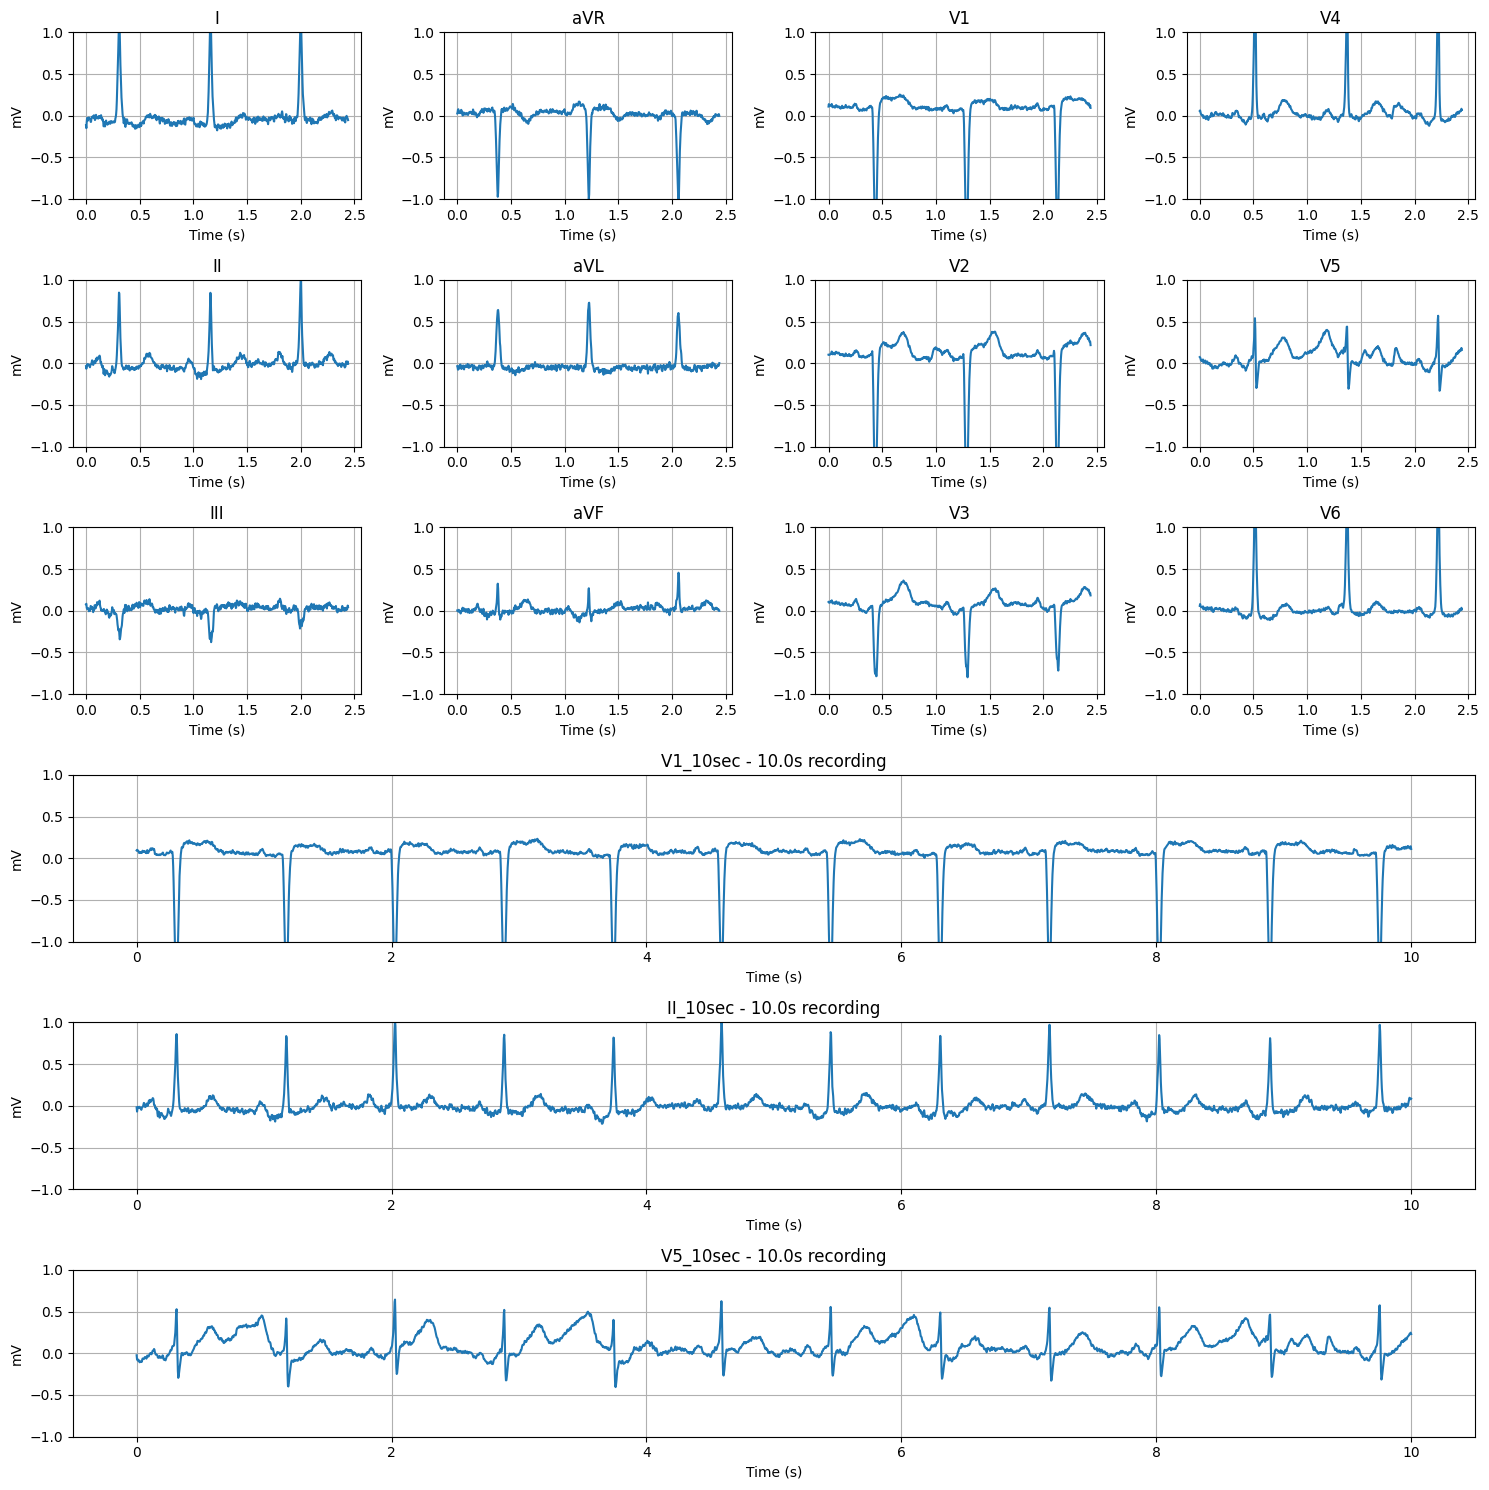

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

def plot_resampled_ecgs(resampled_data, durations, figsize=(15, 15)):
    """
    Plot the resampled ECG leads using a custom layout.
    
    Layout:
      - Rows 1–3: 4 leads per row:
            Row 1: ['I', 'aVR', 'V1', 'V4']
            Row 2: ['II', 'aVL', 'V2', 'V5']
            Row 3: ['III', 'aVF', 'V3', 'V6']
      - Row 4: 'V1_10sec' spans all 4 columns.
      - Row 5: 'II_10sec' spans all 4 columns.
      - Row 6: 'V5_10sec' spans all 4 columns.
    
    The x-axis is the time axis (in seconds) computed from duration for each lead.
    
    Args:
        resampled_data (dict): Dictionary mapping lead names to 1D numpy arrays (resampled).
        durations (dict): Dictionary mapping lead names to recording durations in seconds.
        figsize (tuple): Figure size.
    """
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(6, 4, height_ratios=[1, 1, 1, 1, 1, 1])
    groups = [
        ['I', 'aVR', 'V1', 'V4'],
        ['II', 'aVL', 'V2', 'V5'],
        ['III', 'aVF', 'V3', 'V6'],
    ]
    
    # Plot first three rows
    for i, group in enumerate(groups):
        for j, lead in enumerate(group):
            ax = fig.add_subplot(gs[i, j])
            if lead in resampled_data:
                data = resampled_data[lead]
                dur = durations.get(lead, 2.44)
                t = np.linspace(0, dur, len(data))
                ax.plot(t, data)
                ax.set_xlabel("Time (s)")
                ax.set_title(lead)
                ax.set_ylabel("mV")
                ax.grid(True)
                ax.set_ylim(-1, 1)
            else:
                ax.text(0.5, 0.5, f"{lead}\nData not found", 
                        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                ax.axis('off')
    
    # Plot 10-second leads individually
    long_leads = {
        3: 'V1_10sec',
        4: 'II_10sec',
        5: 'V5_10sec'
    }
    
    for row, lead in long_leads.items():
        ax = fig.add_subplot(gs[row, :])
        if lead in resampled_data:
            data = resampled_data[lead]
            dur = durations.get(lead, 10.0)
            t = np.linspace(0, dur, len(data))
            ax.plot(t, data)
            ax.set_xlabel("Time (s)")
            ax.set_title(f"{lead} - {dur}s recording")
            ax.set_ylabel("mV")
            ax.grid(True)
            ax.set_ylim(-1, 1)
        else:
            ax.text(0.5, 0.5, f"{lead}\nData not found", 
                    horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_resampled_ecgs(resampled_data, lead_durations)


## Get text from the pdf

In [ ]:
from pdf2image import convert_from_path
from PIL import Image
import pytesseract
import tempfile 

def pdf_to_temp_image(pdf_path, dpi=300):
    """
    Converts the first page of the given PDF into an image at the specified dpi.
    Displays the image and returns it.
    
    Args:
        pdf_path (str): The path to the PDF file.
        dpi (int): The resolution for conversion.
    
    Returns:
        PIL.Image.Image: The converted image.
    """
    images = convert_from_path(pdf_path, dpi=dpi)
    if not images:
        raise ValueError("No images were generated from the PDF.")
    
    im = images[0]
    #im.show()  # display the image
    
    #the function returns the image object itself.
    return im

def get_text_OCR(pdf_path, sections_coordinates, dpi=300):
    """
    Extracts text from specified regions of a PDF file using OCR.
    
    This function converts the PDF to an image via pdf_to_temp_image, then
    for each section defined in sections_coordinates (each given as two coordinate pairs),
    it computes the bounding rectangle (i.e. (left, top, right, bottom)), crops that region,
    and runs OCR.
    
    Args:
        pdf_path (str): Path to the PDF file.
        sections_coordinates (dict): Dictionary mapping section names to coordinates.
            Each value should be a tuple of two tuples: ((x1, y1), (x2, y2)).
            These two coordinates determine the bounding rectangle.
        dpi (int): Resolution for PDF-to-image conversion.
        
    Returns:
        dict: Mapping from section names to the extracted text.
    
    Requirements:
        - pytesseract must be installed.
        - Tesseract OCR must be installed on your system.
    """
    # Convert PDF to image using the existing pdf_to_temp_image function
    im = pdf_to_temp_image(pdf_path, dpi=dpi)
    extracted_text = {}
    
    for section, coords in sections_coordinates.items():
        if len(coords) == 2:
            (x1, y1), (x2, y2) = coords
            left = min(x1, x2)
            top = min(y1, y2)
            right = max(x1, x2)
            bottom = max(y1, y2)
            box = (left, top, right, bottom)
        elif len(coords) == 4:
            box = coords
        else:
            print(f"Invalid coordinates provided for section '{section}': {coords}")
            extracted_text[section] = ""
            continue
        
        # Crop the region from the image
        region = im.crop(box)
        # Run OCR on the cropped region
        text = pytesseract.image_to_string(region)
        extracted_text[section] = text.strip()
        print(f"  Extracted text: '{text.strip()}'")
        
    
    return extracted_text

# Example usage with the existing coordinates
sections = {
    "muestra-fecha": ((1292, 88), (1826, 149)),
    "Tasa-vent(LPM)": ((1099, 166), (1199, 212)),
    "Intervalo-Pr(ms)": ((1122, 211), (1191, 251)),
    "Duracion-QRS(ms)": ((1095, 248), (1193, 290)),
    "QT/QTc(ms)": ((1187, 329), (1032, 287)),
    "Ejes-P-R-T": ((1028, 328), (1318, 377)),
    "Diagnosis": ((1388, 170), (2600, 491)),
    "Indic.-prueba": ((610, 520), (1327, 566)),
    "Confirmado": ((2237, 580), (2577, 651)),
    "ECG-units": ((37, 2373), (1100, 2432))
}

# # Use the path to your PDF file
# pdf_path = "/Users/air/Desktop/BSC Projects/PDFconverter/PDF2JSON/Correct/format2/test/test_format2.pdf"

# # # Extract text using OCR
# ocr_results = get_text_OCR(pdf_path, sections)
# print("OCR Results:")
# print(ocr_results)

  Extracted text: '09-JUN-2024 05:00:10'
  Extracted text: '70)'
  Extracted text: '188'
  Extracted text: '74'
  Extracted text: '412/444'
  Extracted text: '65 17 78'
  Extracted text: 'Ritmo sinusal normal

Infarto anterior , edad indeterminada

ECG anémalo

Cuando se compra con el ECG de 04-FEB-2023 14:43,
No se encontré ningtin cambio significativo'
  Extracted text: ''
  Extracted text: 'No confirmado'
  Extracted text: '25mm/s 10mm/mV 40Hz 9.0.7 12SL241 CID: 1'
OCR Results:
{'muestra-fecha': '09-JUN-2024 05:00:10', 'Tasa-vent(LPM)': '70)', 'Intervalo-Pr(ms)': '188', 'Duracion-QRS(ms)': '74', 'QT/QTc(ms)': '412/444', 'Ejes-P-R-T': '65 17 78', 'Diagnosis': 'Ritmo sinusal normal\n\nInfarto anterior , edad indeterminada\n\nECG anémalo\n\nCuando se compra con el ECG de 04-FEB-2023 14:43,\nNo se encontré ningtin cambio significativo', 'Indic.-prueba': '', 'Confirmado': 'No confirmado', 'ECG-units': '25mm/s 10mm/mV 40Hz 9.0.7 12SL241 CID: 1'}


# Output as Json

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

def create_ecg_json(resampled_data, lead_durations, ocr_results):
    """
    Combines ECG waveform data and text data into a standardized JSON format.
    
    Args:
        resampled_data (dict): Dictionary of resampled lead data
        lead_durations (dict): Dictionary of lead durations in seconds
        ocr_results (dict): Dictionary of OCR text extraction results
        
    Returns:
        str: JSON-formatted string representing the ECG report
    """
    # Add diagnostic prints to check data uniqueness
    print("\n=== DIAGNOSTIC: Checking resampled_data for uniqueness ===")
    for lead, data in resampled_data.items():
        print(f"  {lead}: {len(data)} samples, min={np.min(data):.4f}, max={np.max(data):.4f}")
    print("=== END DIAGNOSTIC ===\n")
    
    # Calculate sampling rate for each lead
    sampling_rates = {lead: len(data)/lead_durations[lead] for lead, data in resampled_data.items()}
    
    # Create the text metadata section
    metadata = {
        "muestra-fecha": ocr_results.get("muestra-fecha", ""),
        "genero-edad": ocr_results.get("genero-edad", ""),
        "Tasa-vent(LPM)": ocr_results.get("Tasa-vent(LPM)", ""),
        "Intervalo-Pr(ms)": ocr_results.get("Intervalo-Pr(ms)", ""),
        "Duracion-QRS(ms)": ocr_results.get("Duracion-QRS(ms)", ""),
        "QT/QTc(ms)": ocr_results.get("QT/QTc(ms)", ""),
        "Ejes-P-R-T": ocr_results.get("Ejes-P-R-T", ""),
        "Diagnosis": ocr_results.get("Diagnosis", ""),
        "Indic.-prueba": ocr_results.get("Indic.-prueba", ""),
        "Confirmado": ocr_results.get("Confirmado", ""),
        "ECG-units": ocr_results.get("ECG-units", "")
    }
    
    # Create the lead data section
    lead_data = {}
    for lead, data in resampled_data.items():
        # Create time array based on duration and number of samples
        duration = lead_durations[lead]
        time_values = np.linspace(0, duration, len(data)).tolist()
        
        # Make a deep copy of the data to ensure we have unique arrays
        # This fixes the issue where all leads have the same data in the JSON
        amplitude_data = np.copy(data).tolist()
        
        lead_data[lead] = {
            "duration_seconds": duration,
            "sampling_rate_hz": sampling_rates[lead],
            "num_samples": len(data),
            "time_values": time_values,
            "amplitude_mv": amplitude_data  # Use the copied data
        }
        
        # Verify the copied data matches original data
        print(f"Lead {lead}: First 3 values: {amplitude_data[:3]}")
   
    # Combine both sections
    ecg_report = {
        "metadata": metadata,
        "leads": lead_data
    }
    
    # Convert to JSON string with indentation for readability
    json_str = json.dumps(ecg_report, indent=2)
    
    return json_str
# Example usage
# if 'resampled_data' in globals() and 'lead_durations' in globals() and 'ocr_results' in globals():
#     json_output = create_ecg_json(resampled_data, lead_durations, ocr_results)
#     print("ECG JSON Output:")
#     print(json_output)
# else:
#     print("Required data not available. Make sure to run the resampling and OCR extraction cells first.")


=== DIAGNOSTIC: Checking resampled_data for uniqueness ===
  I: 732 samples, min=-0.1749, max=1.1335
  aVR: 732 samples, min=-1.0682, max=0.1712
  V1: 732 samples, min=-1.6201, max=0.2544
  V4: 732 samples, min=-0.1202, max=1.7035
  II: 732 samples, min=-0.1897, max=1.0128
  aVL: 732 samples, min=-0.1437, max=0.7259
  V2: 732 samples, min=-1.6490, max=0.3795
  V5: 732 samples, min=-0.3296, max=0.5693
  III: 732 samples, min=-0.3761, max=0.1450
  aVF: 732 samples, min=-0.1393, max=0.4564
  V3: 732 samples, min=-0.7970, max=0.3627
  V6: 732 samples, min=-0.1119, max=1.6314
  V1_10sec: 3000 samples, min=-1.6589, max=0.2335
  II_10sec: 3000 samples, min=-0.2159, max=1.0213
  V5_10sec: 3000 samples, min=-0.4057, max=0.6437
=== END DIAGNOSTIC ===

Lead I: First 3 values: [-0.11485149070912855, -0.14847879267427794, -0.07444815089453918]
Lead aVR: First 3 values: [0.02763152630289662, 0.0425130797423613, 0.07390285248672455]
Lead V1: First 3 values: [0.11022106291625887, 0.1401085451485485, 

# Complete ECG Processing Pipeline

Process a PDF file through the entire pipeline to extract ECG waveform data and metadata as JSON.

Processing ECG PDF: /Users/air/Desktop/BSC Projects/PDFconverter/PDF2JSON/Correct/format2/test/test_format2.pdf
Step 1: Extracting SVG from PDF...
✓ SVG extracted to temp file
Step 2: Filtering SVG for ECG waveforms...
✓ Filtered SVG: 21 ECG paths found
Step 3: Extracting ECG coordinate data...
Found 21 paths in SVG file
Processing path 1: calibration_1
  ✓ Extracted 60 points for calibration_1
    X range: 12.76 to 29.48
    Y range: 162.43 to 190.78
Processing path 2: calibration_2
  ✓ Extracted 60 points for calibration_2
    X range: 12.76 to 29.48
    Y range: 232.31 to 260.66
Processing path 3: calibration_3
  ✓ Extracted 60 points for calibration_3
    X range: 12.76 to 29.48
    Y range: 302.19 to 330.54
Processing path 4: I
  ✓ Extracted 1238 points for I
    X range: 30.62 to 205.96
    Y range: 158.54 to 195.77
Processing path 5: II
  ✓ Extracted 1238 points for II
    X range: 30.62 to 205.96
    Y range: 231.60 to 266.04
Processing path 6: III
  ✓ Extracted 1238 points for

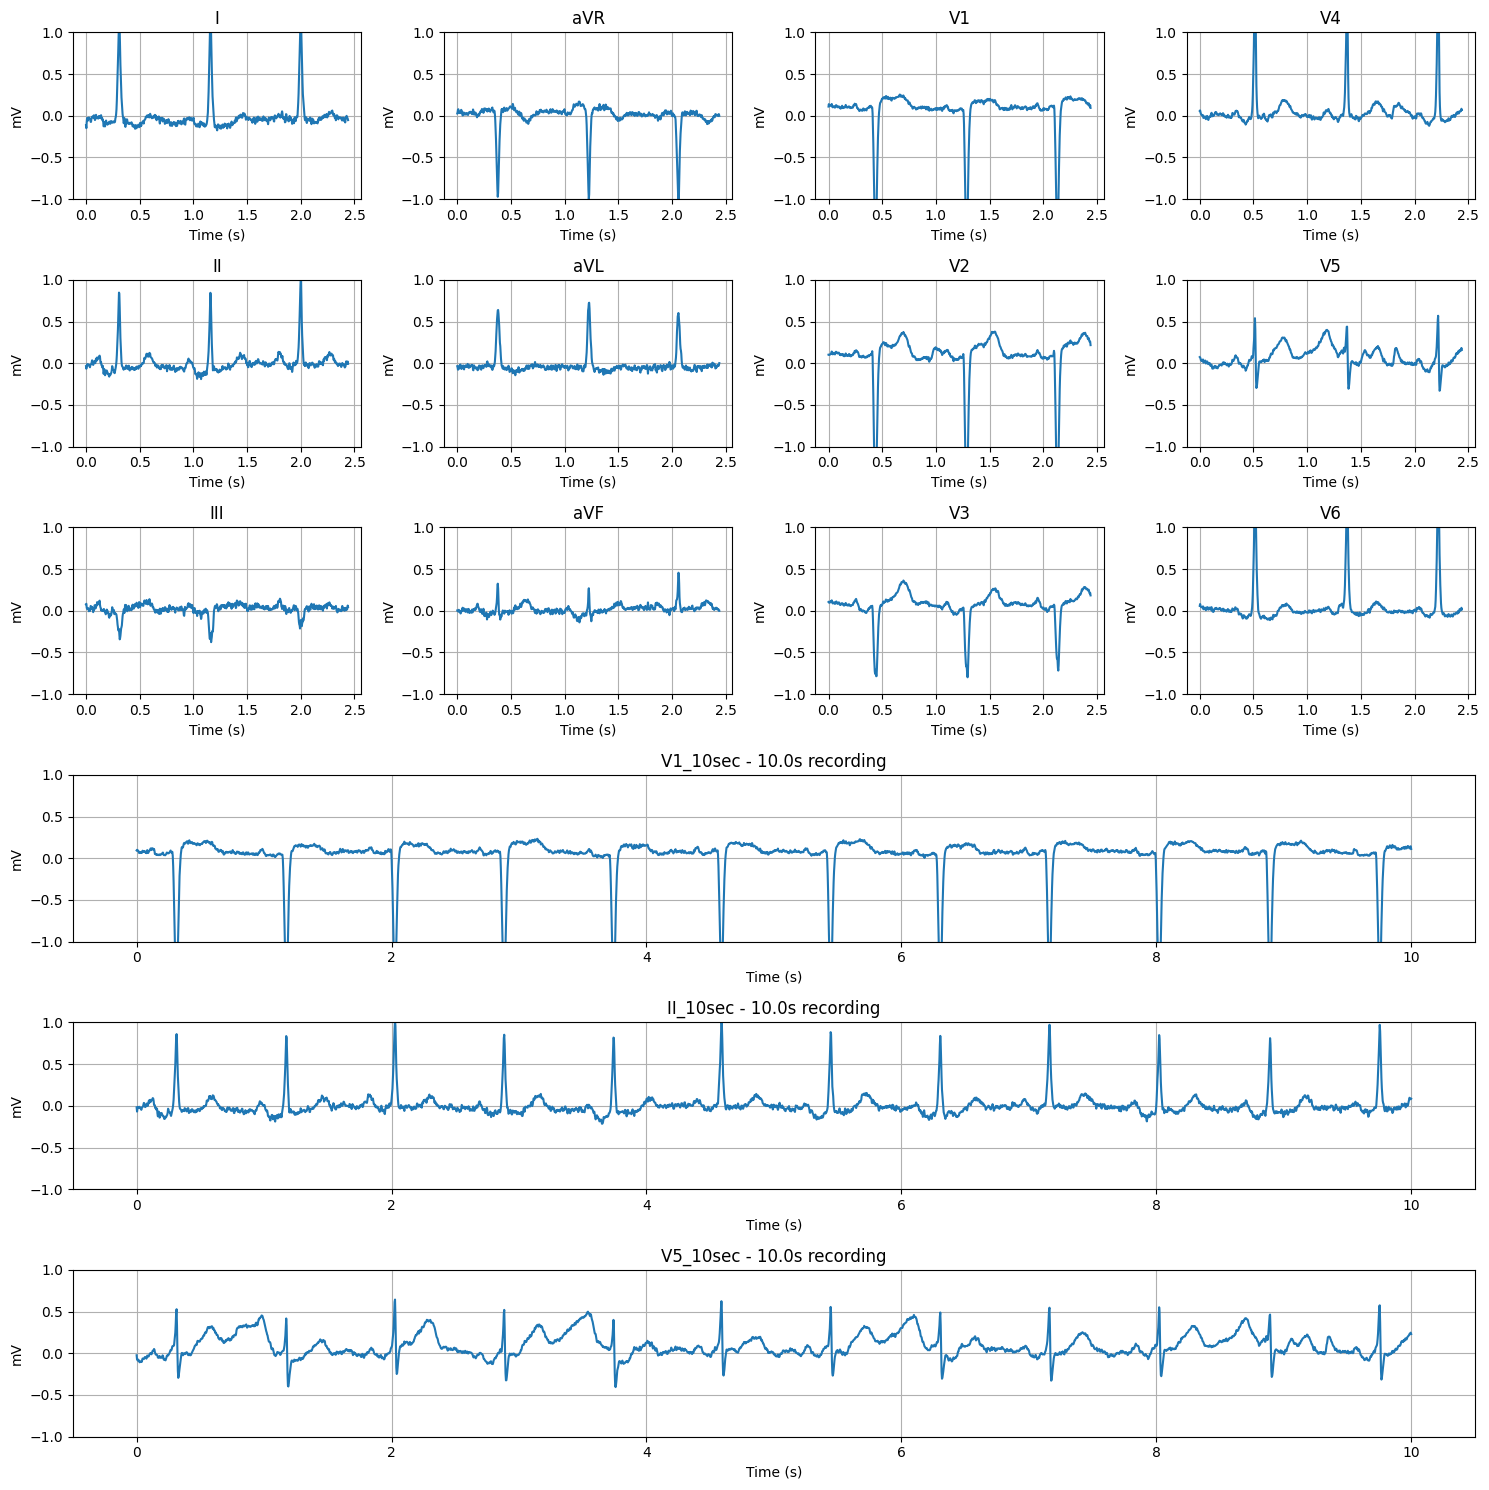

Cleaning up temporary files...
✓ Cleaned up 2 temporary files

🎉 ECG processing completed successfully!
📊 Output file: test_format2_ecg_data.json
📈 Leads processed: 15


In [ ]:
import json
import os
import tempfile
from pathlib import Path

def process_ecg_pdf_to_json(pdf_path, output_dir=".", output_filename=None, show_plot=True):
    """
    Complete pipeline to process an ECG PDF file and extract waveform data and metadata as JSON.
    
    Args:
        pdf_path (str): Path to the input PDF file
        output_dir (str): Directory to save the output JSON file (default: current directory)
        output_filename (str, optional): Custom filename for output JSON (if None, uses PDF filename)
        show_plot (bool): Whether to display the final ECG plots (default: True)
        
    Returns:
        dict: Results with success status, JSON content, and output file path
    """
    result = {
        'success': False,
        'json_content': '',
        'output_file_path': '',
        'errors': [],
        'temp_files_cleaned': []
    }
    
    temp_files_to_clean = []
    
    try:
        print(f"Processing ECG PDF: {pdf_path}")
        
        # Define OCR sections coordinates (hard-coded values)
        sections = {
            "muestra-fecha": ((1292, 88), (1826, 149)),
            "genero-edad": (( 32  , 329 ),( 442  , 394 )),
            "Tasa-vent(LPM)": ((1099, 166), (1199, 212)),
            "Intervalo-Pr(ms)": ((1122, 211), (1191, 251)),
            "Duracion-QRS(ms)": ((1095, 248), (1193, 290)),
            "QT/QTc(ms)": ((1187, 329), (1032, 287)),
            "Ejes-P-R-T": ((1028, 328), (1318, 377)),
            "Diagnosis": ((1388, 170), (2600, 491)),
            "Indic.-prueba": ((610, 520), (1327, 566)),
            "Confirmado": ((2237, 580), (2577, 651)),
            "ECG-units": ((37, 2373), (1100, 2432))
        }
        
        # Step 1: Extract SVG from PDF
        print("Step 1: Extracting SVG from PDF...")
        svg_result = extract_svg_from_pdf(pdf_path)
        if not svg_result['success']:
            result['errors'].extend(svg_result['errors'])
            return result
        
        temp_files_to_clean.append(svg_result['temp_file_path'])
        print(f"✓ SVG extracted to temp file")
        
        # Step 2: Filter SVG to keep only stroke-width=15 paths
        print("Step 2: Filtering SVG for ECG waveforms...")
        filter_result = filter_svg_stroke_width_15(svg_result['temp_file_path'])
        if not filter_result['success']:
            result['errors'].extend(filter_result['errors'])
            return result
        
        temp_files_to_clean.append(filter_result['temp_file_path'])
        print(f"✓ Filtered SVG: {filter_result['filtered_paths']} ECG paths found")
        
        # Step 3: Extract ECG data from filtered SVG
        print("Step 3: Extracting ECG coordinate data...")
        ecg_data = extract_ecg_data_from_svg(filter_result['temp_file_path'])
        if not ecg_data['success']:
            result['errors'].extend(ecg_data['errors'])
            return result
        
        print(f"✓ ECG data extracted: {len(ecg_data['data'])} leads found")
        
        # Step 4: Get calibration values
        print("Step 4: Getting calibration values...")
        calibration_results = get_calibration(ecg_data)
        if not calibration_results:
            result['errors'].append("Failed to get calibration values")
            return result
        
        print(f"✓ Calibration values obtained for {len(calibration_results)} calibration signals")
        
        # Step 5: Apply calibration to convert to mV
        print("Step 5: Applying calibration (converting to mV)...")
        calibrated_data = apply_calibration_to_leads(ecg_data, calibration_results)
        if not calibrated_data:
            result['errors'].append("Failed to apply calibration")
            return result
        
        print(f"✓ Calibration applied to {len(calibrated_data)} leads")
        
        # Step 6: Resample to target frequency
        print("Step 6: Resampling to 300 Hz...")
        resampled_data, lead_durations = resample_ecg_leads(calibrated_data, output_fs=300)
        if not resampled_data:
            result['errors'].append("Failed to resample ECG data")
            return result
        
        print(f"✓ Resampled {len(resampled_data)} leads to 300 Hz")
        
        # Step 7: Extract text using OCR
        print("Step 7: Extracting text metadata with OCR...")
        ocr_results = get_text_OCR(pdf_path, sections)
        print(f"✓ OCR completed for {len(sections)} text regions")
        
        # Step 8: Create JSON output
        print("Step 8: Creating JSON output...")
        json_content = create_ecg_json(resampled_data, lead_durations, ocr_results)
        
        # Step 9: Save JSON to file
        if output_filename is None:
            pdf_name = Path(pdf_path).stem
            output_filename = f"{pdf_name}_ecg_data.json"
        
        output_file_path = Path(output_dir) / output_filename
        with open(output_file_path, 'w', encoding='utf-8') as f:
            f.write(json_content)
        
        print(f"✓ JSON saved to: {output_file_path}")
        
        # Step 10: Display plots if requested
        if show_plot:
            print("Step 10: Displaying ECG plots...")
            plot_resampled_ecgs(resampled_data, lead_durations)
        
        result['success'] = True
        result['json_content'] = json_content
        result['output_file_path'] = str(output_file_path)
        
    except Exception as e:
        result['errors'].append(f"Unexpected error in pipeline: {str(e)}")
        import traceback
        traceback.print_exc()
    
    finally:
        # Clean up temporary files
        print("Cleaning up temporary files...")
        for temp_file in temp_files_to_clean:
            try:
                if os.path.exists(temp_file):
                    os.unlink(temp_file)
                    result['temp_files_cleaned'].append(temp_file)
            except Exception as e:
                print(f"Warning: Could not clean up temp file {temp_file}: {e}")
        
        if result['temp_files_cleaned']:
            print(f"✓ Cleaned up {len(result['temp_files_cleaned'])} temporary files")
    
    if result['success']:
        print(f"\n🎉 ECG processing completed successfully!")
        print(f"📊 Output file: {result['output_file_path']}")
        print(f"📈 Leads processed: {len(resampled_data) if 'resampled_data' in locals() else 'Unknown'}")
    else:
        print(f"\n❌ ECG processing failed:")
        for error in result['errors']:
            print(f"  - {error}")
    
    return result

# Example usage:
# pdf_file = "/Users/air/Desktop/BSC Projects/PDFconverter/PDF2JSON/Correct/format2/test/test_format2.pdf"
# result = process_ecg_pdf_to_json(pdf_file, output_dir="./", show_plot=True)

# Process a whole folder

In [15]:

def process_pdf_folder(input_folder, output_folder=None):
    """
    Process all PDF files in a folder and convert them to JSON.
    
    Args:
        input_folder (str): Path to folder containing PDF files
        output_folder (str, optional): Path to output folder. If None, defaults to "Json-Output" 
                                      in the same parent directory as input_folder
    
    Returns:
        dict: Statistics about the processing
    """
    import os
    import shutil
    from pathlib import Path
    
    # Ensure input folder exists
    input_path = Path(input_folder)
    if not input_path.exists() or not input_path.is_dir():
        raise ValueError(f"Input folder does not exist: {input_folder}")
    
    # Set up output folder
    if output_folder is None:
        output_path = input_path.parent / "Json-Output"
    else:
        output_path = Path(output_folder)
    
    # Create output folder if it doesn't exist
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Create failures subfolder
    failures_path = output_path / "Failures"
    failures_path.mkdir(exist_ok=True)
    
    # Get all PDF files in the input folder
    pdf_files = [f for f in input_path.iterdir() if f.is_file() and f.suffix.lower() == '.pdf']
    
    # Statistics
    stats = {
        'total_files': len(pdf_files),
        'successful': 0,
        'failed': 0,
        'failed_files': []
    }
    
    # Process each PDF file
    for i, pdf_file in enumerate(pdf_files, 1):
        print(f"\nProcessing {pdf_file.name} ({i}/{stats['total_files']})...")
        
        try:
            # Process the PDF without showing plots
            result = process_ecg_pdf_to_json(
                pdf_path=str(pdf_file),
                output_dir=str(output_path),
                output_filename=None,  # Use default filename based on PDF name
                show_plot=False
            )
            
            if result['success']:
                stats['successful'] += 1
                print(f"✅ Successfully processed: {pdf_file.name}")
            else:
                stats['failed'] += 1
                stats['failed_files'].append(pdf_file.name)
                print(f"❌ Failed to process: {pdf_file.name}")
                
                # Copy failed file to failures folder
                shutil.copy2(pdf_file, failures_path / pdf_file.name)
                print(f"   Copied to failures folder: {failures_path / pdf_file.name}")
        
        except Exception as e:
            stats['failed'] += 1
            stats['failed_files'].append(pdf_file.name)
            print(f"❌ Error processing {pdf_file.name}: {str(e)}")
            
            # Copy failed file to failures folder
            shutil.copy2(pdf_file, failures_path / pdf_file.name)
            print(f"   Copied to failures folder: {failures_path / pdf_file.name}")
    
    # Print summary statistics
    print("\n" + "="*50)
    print(f"PDF Processing Summary:")
    print(f"Total files: {stats['total_files']}")
    if stats['total_files'] > 0:
        print(f"Successfully processed: {stats['successful']} ({stats['successful']/stats['total_files']*100:.1f}% of total)")
        print(f"Failed: {stats['failed']} ({stats['failed']/stats['total_files']*100:.1f}% of total)")
    else:
        print("Successfully processed: 0 (0%)")
        print("Failed: 0 (0%)")
    print(f"Output folder: {output_path}")
    print(f"Failures folder: {failures_path}")
    
    if stats['failed'] > 0:
        print("\nFailed files:")
        for failed_file in stats['failed_files']:
            print(f"  - {failed_file}")
    
    return stats

# Example usage:
stats = process_pdf_folder("/Users/air/Desktop/BSC Projects/PDFconverter/PDF2JSON/Correct/format2", "/Users/air/Desktop/BSC Projects/PDFconverter/PDF2JSON/format2json")


Processing SPBS-1018_100_20240207145411__censored.pdf (1/15)...
Processing ECG PDF: /Users/air/Desktop/BSC Projects/PDFconverter/PDF2JSON/Correct/format2/SPBS-1018_100_20240207145411__censored.pdf
Step 1: Extracting SVG from PDF...
✓ SVG extracted to temp file
Step 2: Filtering SVG for ECG waveforms...
✓ Filtered SVG: 21 ECG paths found
Step 3: Extracting ECG coordinate data...
Found 21 paths in SVG file
Processing path 1: calibration_1
  ✓ Extracted 60 points for calibration_1
    X range: 12.76 to 29.48
    Y range: 162.43 to 190.78
Processing path 2: calibration_2
  ✓ Extracted 60 points for calibration_2
    X range: 12.76 to 29.48
    Y range: 232.31 to 260.66
Processing path 3: calibration_3
  ✓ Extracted 60 points for calibration_3
    X range: 12.76 to 29.48
    Y range: 302.19 to 330.54
Processing path 4: I
  ✓ Extracted 1238 points for I
    X range: 30.62 to 205.96
    Y range: 170.17 to 194.52
Processing path 5: II
  ✓ Extracted 1238 points for II
    X range: 30.62 to 205